In [1]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
import pandas as pd

from scipy.io import savemat
from torch import optim
from model import DSNet
from utils import AvgrageMeter, accuracy, output_metric, NonZeroClipper, print_args
from dataset import prepare_dataset
import numpy as np
import time
import os
import wandb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import torch.nn.functional as F

In [12]:
parser = argparse.ArgumentParser("HSI")
parser.add_argument('--fix_random', action='store_true', default=True, help='fix randomness')
parser.add_argument('--gpu_id', default='1', help='gpu id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--dataset', choices=['Indian', 'Berlin', 'Augsburg','GS','BS'], default='GS', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='test', help='testing mark')
parser.add_argument('--model_name', choices=['conv2d_unmix'], default='conv2d_unmix', help='DSNet')
parser.add_argument('--batch_size', type=int, default=128, help='number of batch size')
parser.add_argument('--test_freq', type=int, default=5, help='number of evaluation')
parser.add_argument('--patches', type=int, default=11, help='number of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--inference_model', type=str, default='./results/GS_06_conv2d_unmix_p11_97.29_epoch90.pkl', help='inference model')
parser.add_argument('--learning_rate', type=float, default=1e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.9, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0, help='weight_decay')
args = parser.parse_args(args=[])

In [13]:
def train_epoch(model, train_loader, criterion, optimizer,lambda_value=0.5):
    model.train()
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])

    eps = 1e-7
    # add tqdm for progress bar
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        # Ensure batch_data is a Tensor
        if isinstance(batch_data, np.ndarray):
            batch_data = torch.from_numpy(batch_data)

        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()
        batch_target = batch_target.long().cuda()

        # 입력 차원을 조정합니다. (batch_size, channels, sequence_length)
        if batch_data.dim() == 2:
            batch_data = batch_data.unsqueeze(-1)  # (batch_size, channels) -> (batch_size, channels, 1)

        optimizer.zero_grad()
        if 'unmix' in args.model_name:
            re_unmix_nonlinear, re_unmix, batch_pred = model(batch_data)

            band = re_unmix.shape[1]//2  # 2 represents the number of layer
            output_linear = re_unmix[:,0:band] + re_unmix[:,band:band*2]
            re_unmix = re_unmix_nonlinear + output_linear

            cosine_similarity = torch.sum(batch_data * re_unmix, dim=1) / (
                torch.norm(re_unmix, dim=1, p=2) * torch.norm(batch_data, dim=1, p=2) + eps
            )
            # 범위 클램핑
            cosine_similarity = torch.clamp(cosine_similarity, -0.999, 0.999)

            sad_loss = torch.mean(torch.acos(cosine_similarity))
            loss = lambda_value * sad_loss + (1 - lambda_value) * criterion(batch_pred, batch_target)
            
        else:
            batch_pred = model(batch_data)
            loss = criterion(batch_pred, batch_target)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf detected in loss at batch {batch_idx}. Skipping this batch.")
            continue
                
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.item(), n)  # loss.item()으로 접근
        top1.update(prec1[0].item(), n)  # prec1[0].item()으로 접근

        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre

In [14]:
def valid_epoch(model, valid_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(valid_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

        if 'unmix' in args.model_name:
            re_unmix_nonlinear, re_unmix, batch_pred = model(batch_data)

            band = re_unmix.shape[1]//2
            output_linear = re_unmix[:,0:band] + re_unmix[:,band:band*2]
            re_unmix = re_unmix_nonlinear + output_linear

            sad_loss = torch.mean(torch.acos(torch.sum(batch_data * re_unmix, dim=1)/
                        (torch.norm(re_unmix, dim=1, p=2) * torch.norm(batch_data, dim=1, p=2))))
            loss = criterion(batch_pred, batch_target) + sad_loss
        else:
            batch_pred = model(batch_data)
            loss = criterion(batch_pred, batch_target)

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return tar, pre

In [15]:
def test_epoch(model, test_loader):
    pre = []
    probs = []
    probs1 = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
            batch_data = batch_data.cuda()
            batch_target = batch_target.cuda()

            if 'unmix' in args.model_name:
                _, _, batch_pred = model(batch_data)
            else:
                batch_pred = model(batch_data)

            batch_probs = F.softmax(batch_pred, dim=1)  # 확률

            pred_labels = torch.argmax(batch_pred, dim=1)  # logits에서 직접 예측

            pre.extend(pred_labels.cpu().numpy())
            probs.extend(batch_probs.cpu().numpy())
            probs1.extend(batch_pred.cpu().numpy())

    return np.array(pre), np.vstack(probs), np.vstack(probs1)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
print(os.environ["CUDA_VISIBLE_DEVICES"])
if args.fix_random:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
else:
    cudnn.benchmark = True

## prepare dataset
label_train_loader, label_test_loader, label_true_loader, band, height, width, num_classes, label, total_pos_true = prepare_dataset(args)
# create model
if args.model_name == 'conv2d_unmix':
    model = DSNet(band, num_classes, args.patches, args.model_name)
else:
    raise KeyError("{} model is unknown.".format(args.model_name))
model = model.cuda()
print("Model Name: {}".format(args.model_name))

In [ ]:
model = model.cuda()

In [ ]:
# criterion
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
criterion = nn.CrossEntropyLoss().cuda()
# Set the optimizer
if 'unmix' in args.model_name:
    params = map(id, model.unmix_decoder.parameters())
    ignored_params = list(set(params))
    base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
    optimizer = torch.optim.Adam([{'params': base_params},{'params': model.unmix_decoder.parameters(), 'lr': 3e-4}],
                                lr = args.learning_rate, weight_decay = args.weight_decay)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

apply_nonegative = NonZeroClipper()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)
#-------------------------------------------------------------------------------
if args.flag_test == 'test':
    model.eval()
    model.load_state_dict(torch.load(args.inference_model))
    pre_u, prob, prob1 = test_epoch(model, label_true_loader)

    prediction_matrix = np.zeros((height, width), dtype=float)
    for i in range(total_pos_true.shape[0]):
        prediction_matrix[total_pos_true[i,0], total_pos_true[i,1]] = pre_u[i] + 1
    # savemat('07_matrix.mat',{'P':prediction_matrix, 'label':label})

    # 예측 및 레이블 데이터 플래트닝 및 타입 변환
    flattened_label = label.flatten().astype(int)
    flattened_prediction = prediction_matrix.flatten().astype(int)
    print(f'flattened_label shape: {flattened_label.shape}')
    print(f'flattened_prediction shape: {flattened_prediction.shape}')
    
    # --- 이 부분을 수정합니다 ---

    # 1. 클래스 개수를 확인합니다. prob의 두 번째 차원 크기입니다.
    num_classes = prob.shape[1]

    # 2. 각 클래스 확률에 대한 열 이름을 생성합니다. (예: prob_class_0, prob_class_1, ...)
    prob_columns = [f'prob_class_{i}' for i in range(num_classes)]
    prob_columns1 = [f'probe_class_{i}' for i in range(num_classes)]

    # 3. 확률 배열(prob)을 DataFrame으로 만듭니다.
    df_probs = pd.DataFrame(prob, columns=prob_columns)
    df_probs1 = pd.DataFrame(prob1, columns=prob_columns1)

    # 4. 실제 레이블과 예측 레이블을 DataFrame으로 만듭니다.
    df_main = pd.DataFrame({
        'target': flattened_label,
        'pred': flattened_prediction
    })

    # 5. 두 DataFrame을 열 기준으로 합칩니다.
    result_df = pd.concat([df_main, df_probs,df_probs1], axis=1)

    # 6. 결과를 새로운 CSV 파일로 저장합니다.
    result_df.to_csv(args.dataset+"_"+args.model_name+'_p'+str(args.patches)+"_2307_result_detailed.csv", index=False)

    # F1 score, precision, and recall calculation
    try:
        f1 = f1_score(flattened_label, flattened_prediction, average='binary')
        precision = precision_score(flattened_label, flattened_prediction, average='binary')
        recall = recall_score(flattened_label, flattened_prediction, average='binary')
    except ValueError as e:
        print(f"Error: {e}. Switching to 'macro' average.")
        f1 = f1_score(flattened_label, flattened_prediction, average='macro')
        precision = precision_score(flattened_label, flattened_prediction, average='macro')
        recall = recall_score(flattened_label, flattened_prediction, average='macro')

    print("**************************************************")
    print(f'Model Output: {args.inference_model}')
    print(f'F1 score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {np.sum(flattened_label == flattened_prediction) / flattened_label.size}') 
else:
    print("start training")
    tic = time.time()
    min_val_obj, best_OA = 0.5, 0
    for epoch in range(args.epoches):
        scheduler.step()

        # train model
        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        OA1, AA_mean1, Kappa1, AA1, precision1, recall1, f1_1 = output_metric(tar_t, pre_t)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}".format(epoch+1, train_obj, train_acc, precision1, recall1, f1_1))

        if 'unmix' in args.model_name: # regularize unmix decoder
            model.unmix_decoder.apply(apply_nonegative)

        if (epoch % args.test_freq == 0) | (epoch == args.epoches - 1):
            model.eval()
            tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
            OA2, AA_mean2, Kappa2, AA2, precision2, recall2, f1_2 = output_metric(tar_v, pre_v)
            print("OA: {:.4f} AA: {:.4f} Kappa: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}".format(OA2, AA_mean2, Kappa2, precision2, recall2, f1_2))
            print("*************************")

            if OA2 > min_val_obj and epoch > 10:
                model_save_path = os.path.join('./results/', args.dataset+'_06_'+args.model_name+'_p'+str(args.patches)+
                                                '_'+str(round(OA2*100, 2))+'_epoch'+str(epoch)+'.pkl')
                torch.save(model.state_dict(), model_save_path)

                min_val_obj = OA2
                best_epoch = epoch
                best_OA = OA2
                best_AA = AA_mean2
                best_Kappa = Kappa2
                best_each_AA = AA2

    toc = time.time()
    print("Running Time: {:.2f}".format(toc-tic))
    print("**************************************************")
    if best_OA == 0:
        model_save_path = os.path.join('./results/', args.dataset+'_'+args.model_name+'_p'+str(args.patches)+
                                        '_'+str(round(OA2*100, 2))+'_epoch'+str(epoch)+'.pkl')
        torch.save(model.state_dict(), model_save_path)
        wandb.save(model_save_path)

print("Final result:")
print("**************************************************")
print("Parameter:") 
print_args(vars(args))

## =====================================

In [9]:
import h5py
with h5py.File('./data/202407_downsampled_gongsan.h5', 'r') as f:
        input = f['input'][:]  # (3000, 3000, 150)
        TR = f['TR'][:]  # (3000, 4000)
        TE = f['TE'][:]

In [10]:
all_ = TR+TE

In [13]:
len(np.nonzero(all_)[0])

3982960

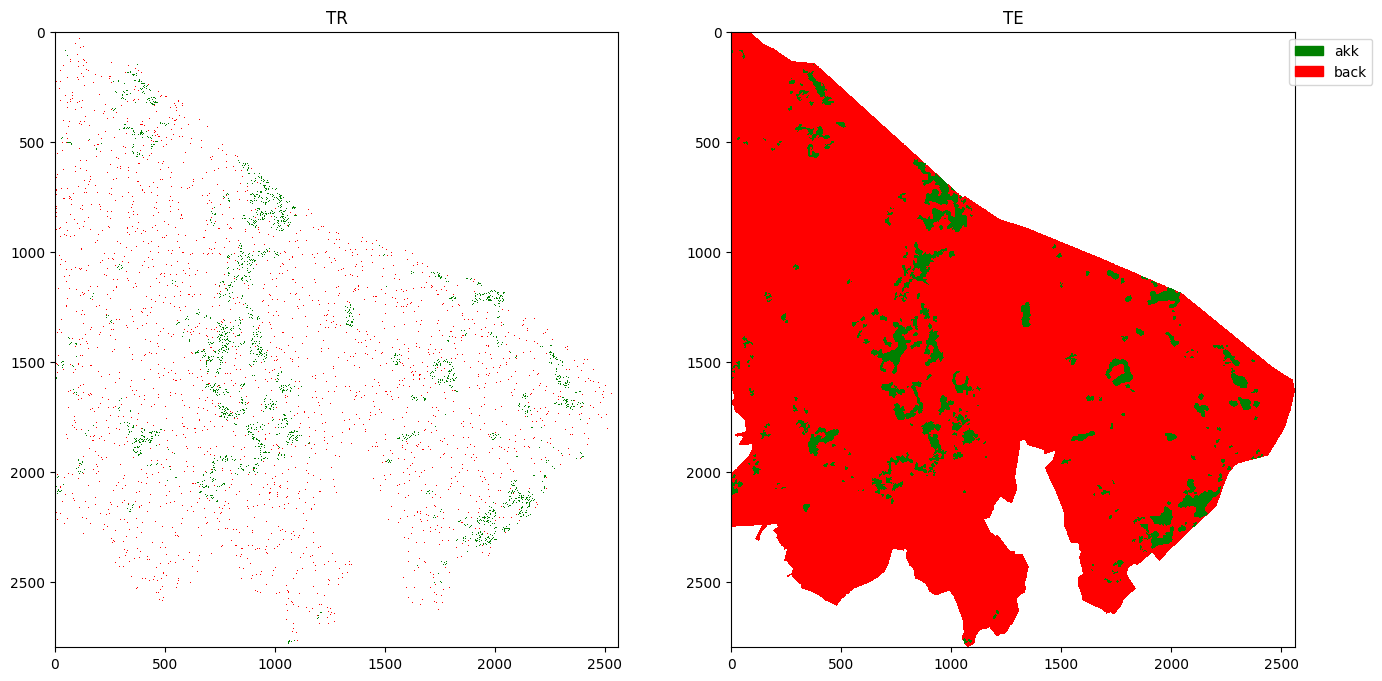

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
cmap = ListedColormap(['white', 'green','red'])

# 2차원 배열 시각화
plt.figure(figsize=(16,9))

# TR 시각화
plt.subplot(1,2,1)
plt.imshow(TR, cmap=cmap, interpolation='nearest')
plt.title('TR')

# TE 시각화 
plt.subplot(1,2,2)
plt.imshow(TE+TR, cmap=cmap, interpolation='nearest')
plt.title('TE')

# 범례 추가
legend_elements = [Patch(facecolor='green', edgecolor='green', label='akk'),
                  Patch(facecolor='red', edgecolor='red', label='back')]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

# 결과 시각화

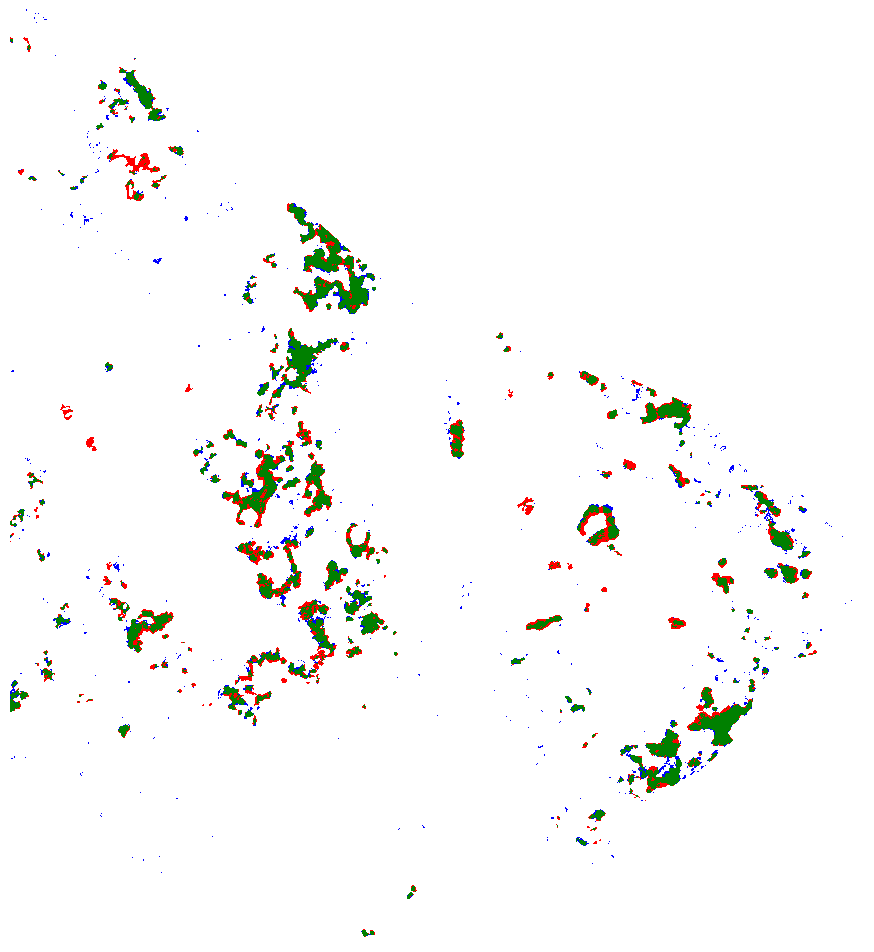

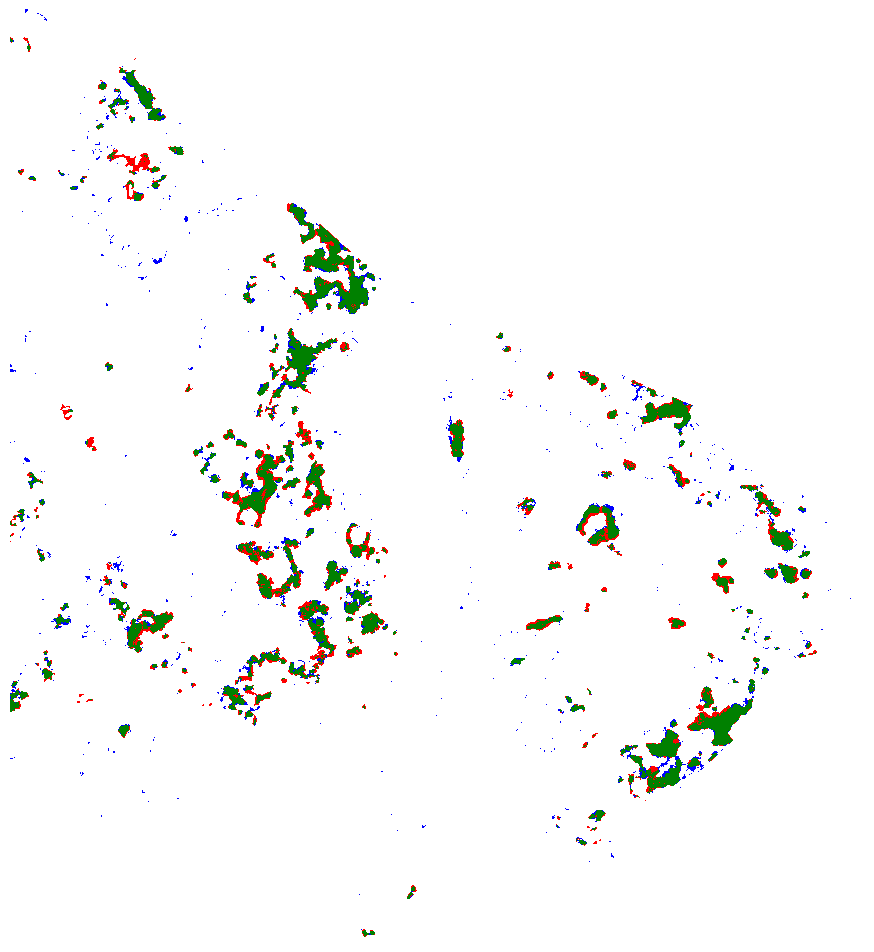

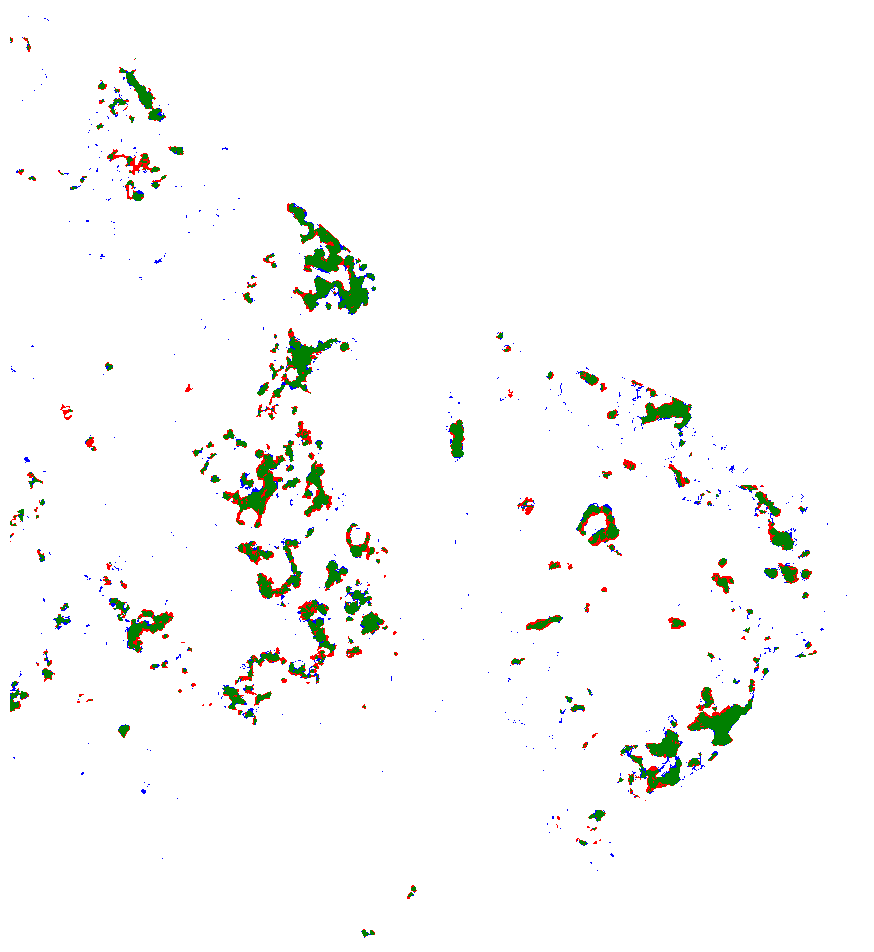

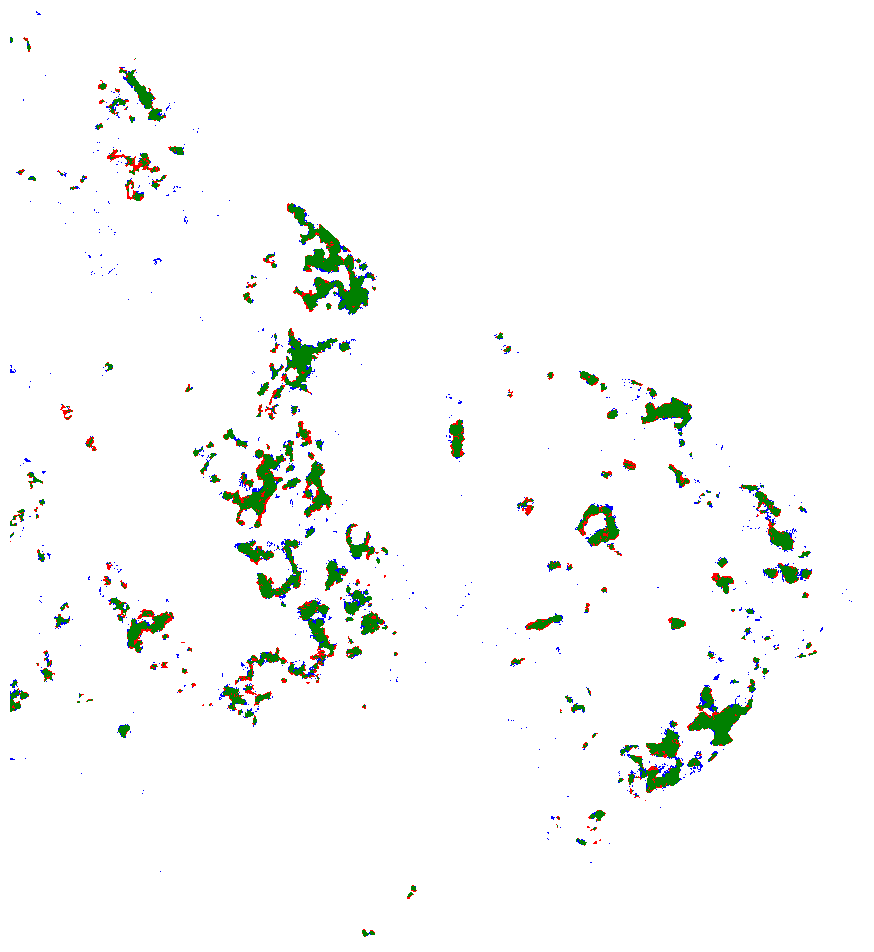

In [8]:
for i in range(9,16,2):
    name='speformer'
    df= pd.read_csv(f'../Group-Aware-Hierarchical-Transformer/results/gs/{name}/gs_2307_{i}_{name}_result.csv')
    #공산성
    ans = df['pred'].to_numpy().reshape(2799,2563)
    gtt = df['gt'].to_numpy().reshape(2799,2563)
    #부소산성
    # ans = df['pred'].to_numpy().reshape(2715,1843)
    # gtt = df['gt'].to_numpy().reshape(2715,1843)
    ans[ans==2]=0
    gtt[gtt==2]=0
    # 결과 배열 생성 
    result = np.zeros_like(ans)
    
    # 예측값과 실제값 비교하여 결과 매핑
    match_mask = (gtt == ans)
    result[match_mask] = gtt[match_mask]
    
    mismatch_mask = ~match_mask
    result[mismatch_mask & (gtt == 1)] = 2  # 미탐지
    result[mismatch_mask & (gtt == 0)] = 3  # 오탐지
    
    # 시각화 설정
    colors = ['white', 'green', 'red', 'blue']
    labels = ['배경', '정탐지', '미탐지', '오탐지']
    cmap = ListedColormap(colors)
    
    # 그래프 생성
    fig = plt.figure(frameon=False)
    fig.set_size_inches(gtt.shape[1] * 2.0 / 600, gtt.shape[0] * 2.0 / 600)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    
    ax.imshow(result, cmap=cmap, interpolation='nearest')
    fig.savefig(f'gs_{i}_{name}_result.png', dpi=600)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

ans1 = df['pred'].to_numpy()
gtt1 = df['target'].to_numpy()

# 혼동 행렬
cm = confusion_matrix(gtt1, ans1)  # 주의: confusion_matrix의 인자는 (y_true, y_pred) 순서입니다.
print("Confusion Matrix:\n", cm)

# precision, recall, f1-score
report = classification_report(gtt1, ans1, digits=4)
print("\nClassification Report:\n", report)

# 또는 개별 지표를 별도로 원할 경우
precision = precision_score(gtt1, ans1, average='weighted')
recall = recall_score(gtt1, ans1, average='weighted')
f1 = f1_score(gtt1, ans1, average='weighted')

print(f"\nPrecision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

Confusion Matrix:
 [[6948816   35574]
 [ 186683    2764]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9738    0.9949    0.9843   6984390
           1     0.0721    0.0146    0.0243    189447

    accuracy                         0.9690   7173837
   macro avg     0.5230    0.5047    0.5043   7173837
weighted avg     0.9500    0.9690    0.9589   7173837


Precision (weighted): 0.9500
Recall (weighted): 0.9690
F1 Score (weighted): 0.9589


## --------------------------------

In [14]:
df1= pd.read_csv('/home1/jmt30269/A2S2K-ResNet/A2S2KResNet/classification_results/S3KAIResNetpatch_9_GS_split_0.97_lr_0.001adam_kernel_240.978_fulldata_with_probs.csv')

# test2= np.zeros((2819*2583))
# gtt =np.zeros((2819*2583))
# for i in range(len(df)):
#     gt[df1['X'][i],df1['Y'][i]] = df1['True Label'][i]
#     test[df1['X'][i],df1['Y'][i]] = df1['Predicted Label'][i]

In [17]:
test2=np.zeros((2799*2563))
test3=np.zeros((2799*2563))

In [18]:
test2[df1['index']]=df1['predicted_class']
# test3[df1['index']]=df1['class_1_prob']

In [46]:
from sklearn.metrics import precision_recall_curve
thres=0.8
precision, recall, thresholds = precision_recall_curve(gtt, test3)
target_recall = 0.8
idx = np.argmin(np.abs(recall - target_recall))
if idx < len(thresholds):
    thres=thresholds[idx]
    print(thres)
else:
    thres= 0.8

1.0


In [19]:
def make_map(pred, gt, height, width, name):
    """예측 결과와 실제 값을 비교하여 시각화 맵을 생성하는 함수
    
    Args:
        pred: 예측값 배열
        gt: 실제값(ground truth) 배열 
        height: 이미지 높이
        width: 이미지 너비
        name: 저장할 파일명
    """
    # 입력 배열 reshape
    pred = np.array(pred).reshape(height, width)
    gt = np.array(gt).reshape(height, width)

    # 결과 배열 생성 
    result = np.zeros_like(pred)
    
    # 예측값과 실제값 비교하여 결과 매핑
    match_mask = (gt == pred)
    result[match_mask] = gt[match_mask]
    
    mismatch_mask = ~match_mask
    result[mismatch_mask & (gt == 1)] = 2  # 미탐지
    result[mismatch_mask & (gt == 0)] = 3  # 오탐지

    # 시각화 설정
    colors = ['white', 'green', 'red', 'blue']
    labels = ['배경', '정탐지', '미탐지', '오탐지']
    cmap = ListedColormap(colors)
    
    # 그래프 생성
    fig = plt.figure(frameon=False)
    fig.set_size_inches(gt.shape[1] * 2.0 / 600, gt.shape[0] * 2.0 / 600)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)

    ax.imshow(result, cmap=cmap, interpolation='nearest')
    fig.savefig(name, dpi=600)

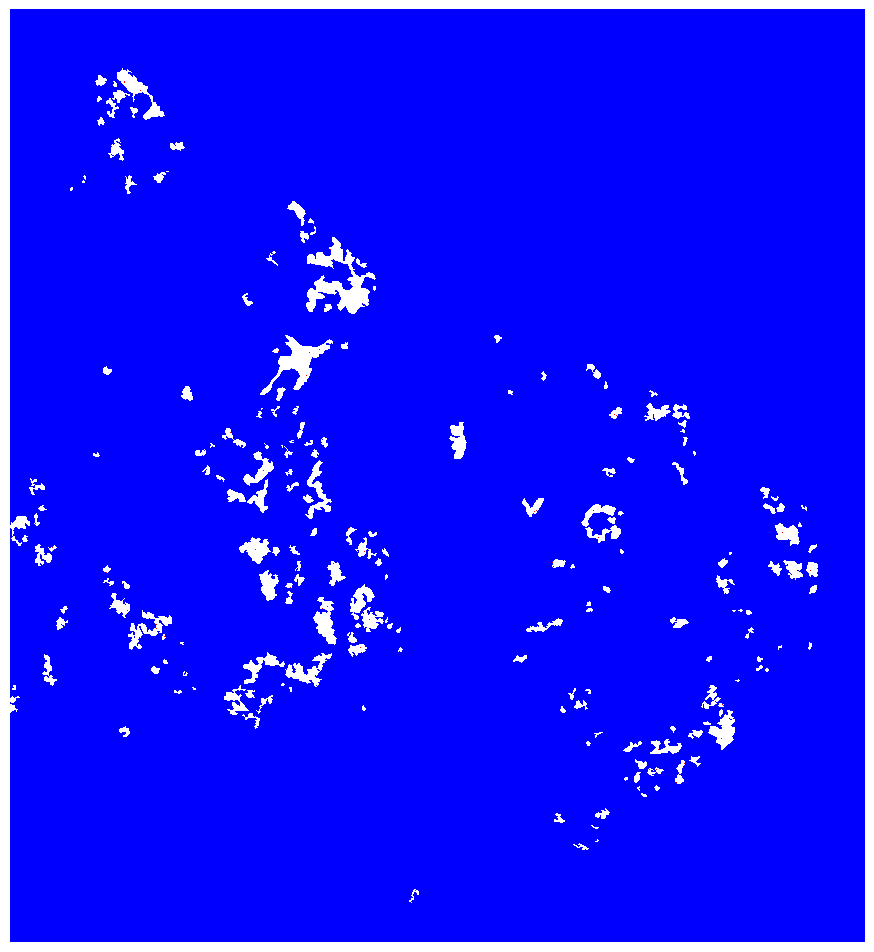

In [20]:
make_map(test2,gtt,2799,2563,f'./a2s2k_11_result.png')